<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab2_Electron/blob/main/Lab2_Thomson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np # math functions
import pandas as pd
import scipy # scientific functions
from scipy.stats import linregress # contains linregress (for linear regression)
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit  # non-linear curve fitting
from scipy.optimize import minimize
import matplotlib.pyplot as plt # for plotting figures and setting their properties
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd # handling data structures (loaded from files)
from sklearn.metrics import r2_score # import function that calculates R^2 score
from sklearn.metrics import mean_squared_error as mse
import json, requests
import itertools
from bs4 import BeautifulSoup
import re
import skimage
import numpy.polynomial.polynomial as poly





In [69]:
N = 320 # Helmholz ring coils
R = 6.7e-2 # Helmholz ring raduis
mu0 = scipy.constants.mu_0
k2 = (4/5)**1.5

url = r'https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Electron/main/CollectData/'
github_url = 'https://github.com/evgeny-kolonsky/Lab2_Electron/blob/main/CollectData/'


## Define class and read data

In [103]:
class observation:
    num = 0
    Ua = 0
    Up = 0
    I = 0
    x = np.array([])
    y = np.array([])
    image = 0
    pngname = ''
    group = ''
    p = 0 # polynomial approximation
    curvature = 0 #  = 1/r, r - radius
    k1 = 0 # E = k1 * Up/d, losses
    
    
    def __init__(self, num, group, Ua, Up, I, x, y):
        self.num = num
        self.group  = group
        self.Ua = Ua
        self.Up = Up
        self.I = I
        self.x = x
        self.y = y
        self.fit()

    def get_image(self):
        self.pngname = pngfiles[self.num]
        self.image = skimage.io.imread(url + self.pngname)
        
    def fit(self):
        self.p = poly.Polynomial.fit(self.x, self.y, deg=3)
        p1 = self.p.deriv(1)
        p2 = self.p.deriv(2)
        self.curvature = np.abs(p2(self.x) / (1 + p1(self.x)**2) **1.5).mean()
        if self.Up != 0:
          yu = self.y /self.Up
          xu = self.x**2 /4/self.Ua/d
          lr = linregress(xu, yu)
          self.k1 = lr.slope

        
        
        
        
#images
soup = BeautifulSoup(requests.get(github_url).text, 'html.parser')
pngfiles = {}
for i in soup.find_all(title=re.compile("\.png$")):
        fname = i.extract().get_text()
        s = fname[:3]
        if s.isdigit():
            pngfiles[int(s)] = fname.replace(' ', '%20')


#experiments
file = 'experiments.csv'
params = pd.read_csv(url + file, index_col='Num')

#datapoints
measurements = ''
file = 'data.txt'
text = requests.get(url+file).text.splitlines()
for line in text:
  ns, xs, ys = line.split('\t')
  if ns != '':
    num = int(ns)
    Ua = params.loc[num]['Ua']
    Up = params.loc[num]['Up']
    I = params.loc[num]['I']
    continue
  else:
    x = np.float32(xs)
    y = np.float32(ys)
  measurements += f'{num} {x} {y} {Ua} {Up} {I}\n'

data = np.genfromtxt(measurements.splitlines(), dtype=float)

num, x, y, Ua, Up, I = data.T

Ua = Ua*1e3 #kV
Up = Up*1e3 #kV
x = x*1e-2 # cm
y = y*1e-2 # cm

#objects

experiment = {}
for n in np.unique(num):
  filter = (num == n)
  x_ = x[filter]
  y_ = y[filter]
      
  Ua_ = Ua[filter][0]
  Up_ = Up[filter][0]
  I_  = I[filter][0]

  if (Up_ == 0) & (I_ == 0):
    group = 'Z' # Zero forces
  elif (Up_ != 0) & (I_ == 0): 
    group = 'E' # Electron in electrostatic field
  elif (Up_ == 0) & (I_ != 0): 
    group = 'B' # Electron in magnetic field
  else:
    group = 'W' # Wien filter

  obs = observation(n, group, Ua_, Up_, I_, x_, y_)
  experiment[n] = obs
  
  

# Zero

<ipython-input-104-1b4f19d4371c>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_, y_, marker='.', color = 'gray',


Text(0.5, 1.0, 'Zero forces correction')

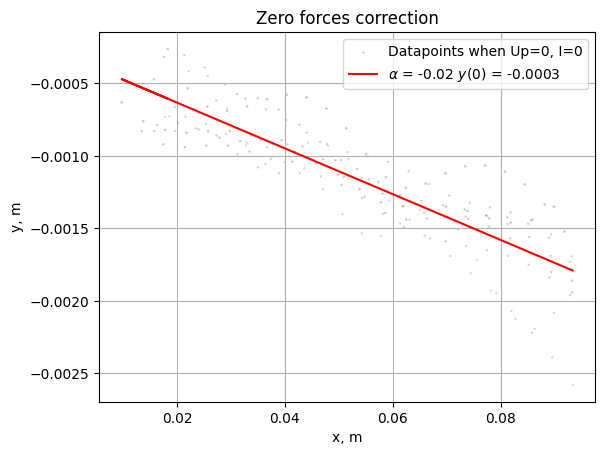

In [104]:
noforces = (Up == 0) & (I == 0)
x_ = x[noforces]
y_ = y[noforces]
Ua_ = Ua[noforces] *1e-3
plt.scatter(x_, y_, marker='.', color = 'gray', 
            s=Ua_, cmap=Ua_, alpha=.3,
            label='Datapoints when Up=0, I=0')

fit = linregress(x_, y_)
alpha = fit.slope
plt.plot(x_, fit.intercept + fit.slope*x_, color='red', label=fr'$\alpha$ = {alpha:.2f} $y(0)$ = {fit.intercept:.4f} ')
plt.grid()
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.legend()
plt.title('Zero forces correction')


Rotate by $\alpha$ to ensure $y=0$ when no forces applied.

In [105]:
cosa, sina = np.cos(alpha), np.sin(alpha)
x, y = x*cosa + y*sina, -x*sina + y*cosa 

for obs in experiment.values():
  x_, y_ = obs.x, obs.y
  obs.x, obs.y = x_*cosa + y_*sina, -x_*sina + y_*cosa   
  obs.fit()

# E-experiment

In [118]:
for obs in experiment.values():
  if obs.group == 'E':
    if (obs.Ua*1e-3 > 2) & (np.abs(obs.Up) <= obs.Ua ):
      print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV, k1: {obs.k1:.3f}')


num:63, Ua: 3.0 kV, Up: -0.5 kV, k1: 0.780
num:64, Ua: 3.0 kV, Up: -1.0 kV, k1: 0.787
num:65, Ua: 3.0 kV, Up: -1.5 kV, k1: 0.734
num:66, Ua: 3.0 kV, Up: -2.0 kV, k1: 0.702
num:67, Ua: 3.0 kV, Up: -2.5 kV, k1: 0.671
num:68, Ua: 3.0 kV, Up: -3.0 kV, k1: 0.666
num:79, Ua: 4.0 kV, Up: -0.5 kV, k1: 0.696
num:80, Ua: 4.0 kV, Up: -0.9 kV, k1: 0.795
num:81, Ua: 4.0 kV, Up: -1.5 kV, k1: 0.769
num:82, Ua: 4.0 kV, Up: -2.0 kV, k1: 0.740
num:83, Ua: 4.0 kV, Up: -2.5 kV, k1: 0.727
num:84, Ua: 4.0 kV, Up: -3.0 kV, k1: 0.703
num:85, Ua: 4.0 kV, Up: -3.5 kV, k1: 0.690
num:86, Ua: 4.0 kV, Up: -4.0 kV, k1: 0.670
num:156, Ua: 2.5 kV, Up: 0.5 kV, k1: 0.826
num:157, Ua: 2.5 kV, Up: 1.0 kV, k1: 0.833
num:158, Ua: 2.5 kV, Up: 2.0 kV, k1: 0.740
num:167, Ua: 3.0 kV, Up: 1.0 kV, k1: 0.890
num:168, Ua: 3.0 kV, Up: 2.0 kV, k1: 0.787
num:169, Ua: 3.0 kV, Up: 3.0 kV, k1: 0.730
num:176, Ua: 4.0 kV, Up: 1.0 kV, k1: 0.881
num:178, Ua: 4.0 kV, Up: 2.0 kV, k1: 0.823
num:179, Ua: 4.0 kV, Up: 3.0 kV, k1: 0.780
num:180, Ua

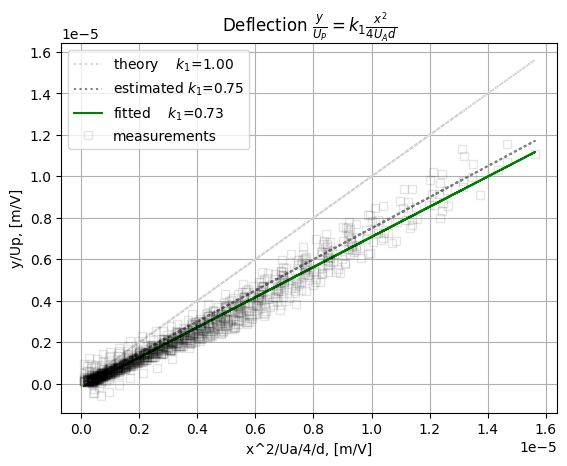

In [131]:
filter =(Up != 0) & (I == 0) # E-experiment
#filter = filter * (Ua*1e-3 > 2) & (np.abs(Up) <= Ua )
filter = filter * (Ua*1e-3 > 2) 
d = 5.5e-2
x_ = x[filter]
y_ = y[filter]
Up_ = Up[filter]
Ua_ = Ua[filter]
 
xu = x_*x_/Ua_/4/d
yu = y_/Up_


fit = linregress(xu, yu)
k1 = fit.slope

plt.plot(xu, 1.00*xu, label=f'theory    $k_1$={1.0:.2f}',c='lightgray', ls='dotted')
plt.plot(xu, 0.75*xu, label=f'estimated $k_1$={.75:.2f}',c='gray', ls='dotted')
plt.plot(xu, fit.intercept + fit.slope*xu, 
                      label=f'fitted    $k_1$={fit.slope:.2f}',c='green')
plt.plot(xu, yu, label='measurements', c='black', 
            marker='s', fillstyle='none', ls='', alpha=.1)
plt.legend()
plt.grid()
plt.xlabel('x^2/Ua/4/d, [m/V]')
plt.ylabel('y/Up, [m/V]')
plt.title(r'Deflection $\frac{y}{U_P} = k_1 \frac{x^2}{4 U_A d}$');

In [ ]:
for obs in experiment.values():
  if obs.group == 'E':
    print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Ua: {obs.Ua*1e-3:.1f} kV, k1: {obs.k1:.3f}')


In [91]:
N = 320 # Helmholz ring coils
R = 6.7e-2 # Helmholz ring raduis
mu0 = scipy.constants.mu_0
k2 = (4/5)**1.5

# B-experiment

$$
B = \mu_0 \left({4\over 5}\right)^{3/2} {N I\over R} = k_2 \mu_0 {N I\over R}, \quad k_2 \approx 0.7155.
\tag{4}
$$

$$
{e \over m} = {2U_A\over B^2 r^2}.
\tag{5}
$$ 


In [137]:
ems = []
for obs in experiment.values():
  if obs.group == 'B':
    # skip small currents
    if np.abs(obs.I) < .1:
      continue
    B = k2 * mu0 * N /R * obs.I 
    r = 1/ obs.curvature

    em = 2*obs.Ua /(B * r)**2
    ems.append(em)
    print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, I: {obs.I*1e3:-.0f} mA, r: {r*1e2:.1f} cm, B:{B*1e3:.3f} mT, em:{em:.2e} C/kg')
ems = np.array([ems])
np.mean(ems*1e-11), np.std(ems*1e-11)

num:201, Ua: 1.0 kV, I: 100 mA, r: 25.2 cm, B:0.429 mT, em:1.71e+11 C/kg
num:202, Ua: 1.0 kV, I: 150 mA, r: 16.6 cm, B:0.644 mT, em:1.74e+11 C/kg
num:203, Ua: 1.0 kV, I: 200 mA, r: 10.7 cm, B:0.859 mT, em:2.35e+11 C/kg
num:204, Ua: 1.0 kV, I: 250 mA, r: 9.4 cm, B:1.074 mT, em:1.97e+11 C/kg
num:206, Ua: 2.0 kV, I: 100 mA, r: 34.9 cm, B:0.429 mT, em:1.78e+11 C/kg
num:207, Ua: 2.0 kV, I: 150 mA, r: 22.0 cm, B:0.644 mT, em:2.00e+11 C/kg
num:208, Ua: 2.0 kV, I: 200 mA, r: 19.6 cm, B:0.859 mT, em:1.41e+11 C/kg
num:209, Ua: 2.0 kV, I: 250 mA, r: 15.6 cm, B:1.074 mT, em:1.42e+11 C/kg
num:211, Ua: 3.0 kV, I: 100 mA, r: 48.8 cm, B:0.429 mT, em:1.37e+11 C/kg
num:212, Ua: 3.0 kV, I: 150 mA, r: 26.6 cm, B:0.644 mT, em:2.04e+11 C/kg
num:213, Ua: 3.0 kV, I: 200 mA, r: 21.7 cm, B:0.859 mT, em:1.72e+11 C/kg
num:214, Ua: 3.0 kV, I: 250 mA, r: 17.3 cm, B:1.074 mT, em:1.74e+11 C/kg
num:216, Ua: 4.0 kV, I: 100 mA, r: 48.4 cm, B:0.429 mT, em:1.85e+11 C/kg
num:217, Ua: 4.0 kV, I: 150 mA, r: 33.0 cm, B:0.644 

(1.8881186905185627, 0.33857908737941844)

# W-experiment

In [135]:
ems = []
for obs in experiment.values():
  if obs.group == 'W':
    B_ = k2 * mu0 * N /R * obs.I 
    E_ = k1*obs.Up / d
    em = 1/2/obs.Ua * (E_/B_)**2
    ems.append(em)
    print(f'num:{obs.num:n}, Ua: {obs.Ua*1e-3:.1f} kV, Up: {obs.Up*1e-3:.1f} kV I: {obs.I*1e3:-.0f} mA, r: {1/obs.curvature*1e2:.1f} cm, em:{em:.2e} C/kg')
ems = np.array([ems])
np.mean(ems*1e-11), np.std(ems*1e-11)



num:300, Ua: 1.0 kV, Up: 1.0 kV I: -152 mA, r: 43.0 cm, em:2.05e+11 C/kg
num:301, Ua: 1.0 kV, Up: 1.5 kV I: -250 mA, r: 30.9 cm, em:1.71e+11 C/kg
num:302, Ua: 2.0 kV, Up: 1.0 kV I: -110 mA, r: 99.6 cm, em:1.96e+11 C/kg
num:303, Ua: 2.0 kV, Up: 1.5 kV I: -161 mA, r: 56.5 cm, em:2.06e+11 C/kg
num:304, Ua: 2.0 kV, Up: 2.0 kV I: -214 mA, r: 42.0 cm, em:2.07e+11 C/kg
num:305, Ua: 2.0 kV, Up: 3.0 kV I: -336 mA, r: 32.0 cm, em:1.89e+11 C/kg
num:306, Ua: 3.0 kV, Up: 1.5 kV I: -121 mA, r: 55.9 cm, em:2.43e+11 C/kg
num:307, Ua: 3.0 kV, Up: 3.2 kV I: -293 mA, r: 38.1 cm, em:1.89e+11 C/kg
num:308, Ua: 4.0 kV, Up: 1.0 kV I: -81 mA, r: 89.7 cm, em:1.81e+11 C/kg
num:309, Ua: 4.0 kV, Up: 1.9 kV I: -150 mA, r: 78.3 cm, em:1.90e+11 C/kg
num:310, Ua: 4.0 kV, Up: 3.0 kV I: -242 mA, r: 55.2 cm, em:1.82e+11 C/kg
num:311, Ua: 4.0 kV, Up: 4.0 kV I: -327 mA, r: 42.5 cm, em:1.77e+11 C/kg
num:312, Ua: 1.0 kV, Up: -1.0 kV I: 175 mA, r: 54.5 cm, em:1.55e+11 C/kg
num:313, Ua: 1.0 kV, Up: -2.0 kV I: 332 mA, r: 26.1 

(1.747470756083388, 0.2691073173138337)